# Выполнил Аксенов Роман

Для решения поставленной задачи предсказания стоимости жилья на основе объявлений о продаже, разобьем процесс на следующие подзадачи:

1. Постановка ML-задачи
Определение типа задачи машинного обучения, которую мы будем решать, на основе предоставленных данных и целей заказчика.

2. Выбор метрики качества
Выбор и обоснование метрики (или метрик), которые будут использоваться для оценки качества модели.

3. Предварительный разведочный анализ (EDA)
Проведение разведочного анализа данных (EDA), включая изучение статистик, распределений и создание визуализаций, для получения представления о данных и выявления потенциальных проблем.

4. Подготовка данных
Подготовка данных для моделирования, включая обработку пропущенных значений, кодирование категориальных признаков и нормализацию данных, если это необходимо.

5. Создание и оценка базовых моделей
Выбор и обучение простой базовой модели (например, линейной регрессии) и константной модели для установления базового уровня качества предсказаний.

6. Создание и оценка более сложной модели
Выбор, обучение и настройка более сложной модели машинного обучения (например, ансамблевой модели) для улучшения качества предсказаний.

7. Интерпретация модели
Анализ важности признаков и интерпретация результатов модели, чтобы предоставить заказчику понимание, какие факторы влияют на цену недвижимости.


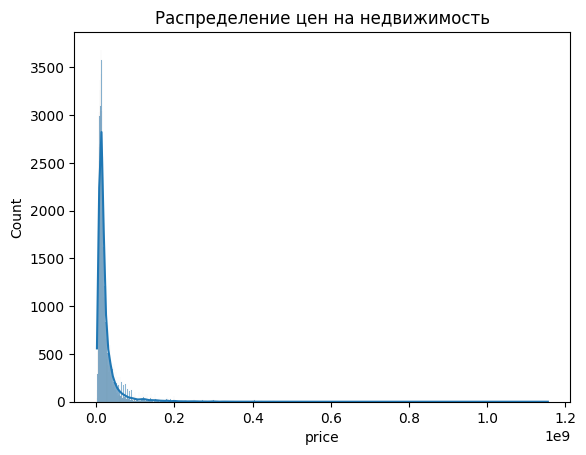

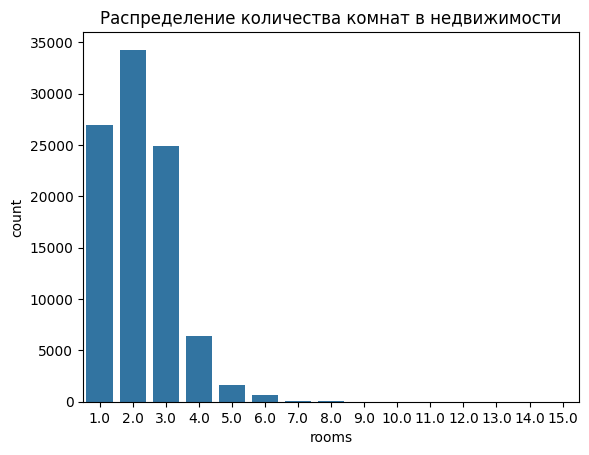

MAE константной модели: 14873766.939843157
MAE линейной регрессии: 5338826.778734969
MAE случайного леса: 2785258.5993447662


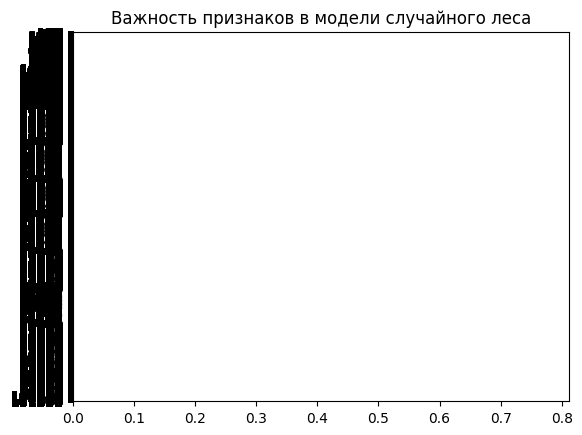

In [1]:
# Подключение необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Загрузка данных
data_path = 'realty_data.csv'
data = pd.read_csv(data_path)
data.head()

## Подзадача 1: Постановка ML-задачи
# Описываем, что на основе данных о продаже недвижимости (цены, площади, количества комнат и др.) мы будем решать задачу регрессии: предсказывать стоимость недвижимости.

## Подзадача 2: Выбор метрики качества
# Объясняем выбор метрики. Для задачи регрессии хорошо подходит MAE, так как она показывает среднюю абсолютную ошибку между предсказанными и фактическими ценами. MAE легко интерпретируется и дает понимание о среднем отклонении предсказаний от истинных значений.

## Подзадача 3: Предварительный разведочный анализ (EDA)
# Визуализируем распределение цен для понимания общего диапазона стоимости недвижимости.
sns.histplot(data['price'], kde=True)
plt.title('Распределение цен на недвижимость')
plt.show()

# Анализируем распределение количества комнат, чтобы увидеть, какие типы квартир встречаются чаще всего.
sns.countplot(x='rooms', data=data)
plt.title('Распределение количества комнат в недвижимости')
plt.show()

## Подзадача 4: Подготовка данных
# Выделяем числовые и категориальные признаки для дальнейшей обработки.
num_features = data.select_dtypes(include=['int64', 'float64']).columns.drop('price').tolist()
cat_features = data.select_dtypes(include=['object']).columns.tolist()

# Создаем пайплайны для обработки числовых и категориальных данных.
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Объединяем обработку в один ColumnTransformer.
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)])

# Подготавливаем признаки и целевую переменную, разделяем на обучающую и тестовую выборки.
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

## Подзадача 5: Создание и оценка базовых моделей
# Обучаем константную модель и модель линейной регрессии, сравниваем их MAE.
dummy_regressor = DummyRegressor(strategy="median")
dummy_regressor.fit(X_train_prepared, y_train)
y_pred_dummy = dummy_regressor.predict(X_test_prepared)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_prepared, y_train)
y_pred_linear = linear_regressor.predict(X_test_prepared)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print(f'MAE константной модели: {mae_dummy}')
print(f'MAE линейной регрессии: {mae_linear}')

## Подзадача 6: Создание и оценка более сложной модели
# Применяем более сложную модель - случайный лес. Это ансамблевая модель, которая часто показывает лучшее качество на разнообразных данных.
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=37)
random_forest_regressor.fit(X_train_prepared, y_train)
y_pred_rf = random_forest_regressor.predict(X_test_prepared)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'MAE случайного леса: {mae_rf}')

## Подзадача 7: Интерпретация модели
# Анализируем важность признаков для модели случайного леса, чтобы понять, какие факторы больше всего влияют на ценообразование.
feature_importances = random_forest_regressor.feature_importances_
sns.barplot(x=feature_importances, y=[str(i) for i in range(len(feature_importances))])
plt.title('Важность признаков в модели случайного леса')
plt.show()  


## Подзадача 1
### Постановка ML-задачи
Задача регрессии была выбрана потому, что целью является предсказание стоимости недвижимости, которая является непрерывной переменной. Регрессия — это тип задачи машинного обучения, который подходит для прогнозирования количественных ответов.

## Подзадача 2 
### Выбор метрики качества
MAE (средняя абсолютная ошибка) была выбрана в качестве метрики качества, потому что она представляет собой среднее значение абсолютных разностей между предсказанными и истинными значениями, что делает её понятной и легко интерпретируемой. MAE позволяет оценить среднюю ошибку в единицах измеряемой величины, что удобно для анализа и сравнения моделей.

## Подзадача 3 
### Предварительный разведочный анализ (EDA)
Визуализация распределения цен и количества комнат позволяет понять основные тенденции и распределения данных, с которыми мы работаем. Это важный шаг, который помогает определить необходимость предобработки данных, такую как нормализация или логарифмирование, а также выявить аномалии или выбросы.

## Подзадача 4 
### Подготовка данных
Разделение признаков на числовые и категориальные, а также их последующая обработка необходимы для корректного обучения моделей. Числовые данные нормализуются для улучшения сходимости модели, а категориальные данные преобразуются в числовые с помощью OneHotEncoding, чтобы модель могла корректно их интерпретировать.

## Подзадача 5 
### Создание и оценка базовых моделей
Обучение константной модели и линейной регрессии, а затем сравнение их MAE позволяет оценить, насколько лучше более сложная модель работает по сравнению с простым базовым уровнем. Это помогает понять, стоит ли усложнять модель дальше.

## Подзадача 6 
### Создание и оценка более сложной модели
Использование случайного леса, ансамблевой модели, позволяет улучшить качество предсказаний благодаря более сложной структуре и возможности моделировать нелинейные зависимости. Подбор гиперпараметров (в данном случае, количество деревьев) улучшает способность модели адаптироваться к данным без переобучения.

## Подзадача 7 
### Интерпретация модели
Анализ важности признаков в модели случайного леса позволяет понять, какие факторы больше всего влияют на цену недвижимости. Это важно не только для улучшения модели, но и для получения бизнес-инсайтов о рынке недвижимости.